In [2]:
import japanize_matplotlib

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pypolyagamma import PyPolyaGamma
from tqdm import tqdm
import matplotlib.cm as cm

# ロジスティック関数
def logistic(x):
    return 1 / (1 + np.exp(-x))

# スティックブレイキング変換でψからπへ変換
def psi_to_pi(psi):
    K = len(psi) + 1
    pi = np.zeros(K)
    stick_remainder = 1.0
    
    for k in range(K-1):
        pi[k] = stick_remainder * logistic(psi[k])
        stick_remainder -= pi[k]
    
    pi[K-1] = stick_remainder
    return pi

# 二乗指数（RBF）カーネル
def rbf_kernel(Z, sigma=1.0, length_scale=1.0):
    """
    RBFカーネル関数
    
    引数:
        Z: 共変量行列 (M x D)
        sigma: 出力スケール
        length_scale: バンド幅
    
    戻り値:
        カーネル行列 (M x M)
    """
    M = Z.shape[0]
    K = np.zeros((M, M))
    
    for i in range(M):
        for j in range(M):
            # ユークリッド距離の二乗
            sq_dist = np.sum((Z[i] - Z[j])**2)
            K[i, j] = sigma**2 * np.exp(-0.5 * sq_dist / (length_scale**2))
    
    # 数値的安定性のために対角成分に小さな値を追加
    K = K + np.eye(M) * 1e-6
    
    return K

# 多項分布ガウス過程モデルのギブスサンプラー
def gibbs_sampler_multinomial_gp(X, Z, n_samples, burn_in, thin=1):
    """
    多項分布ガウス過程モデルのギブスサンプラー
    
    引数:
        X: カウントデータ (M x K)
        Z: 共変量 (M x D)
        n_samples: サンプル数
        burn_in: バーンイン期間
        thin: 間引き間隔
    
    戻り値:
        サンプルされた潜在GP値とパラメータ
    """
    M, K = X.shape
    K = K  # カテゴリ数
    
    # Pólya-gammaサンプラーの初期化
    pg = PyPolyaGamma()
    
    # 共分散行列の計算（固定パラメータ）
    C = rbf_kernel(Z, sigma=1.0, length_scale=1.0)
    
    # 共分散行列の逆行列を計算
    C_inv = np.linalg.inv(C)
    
    # 平均関数の事前分布
    mu0 = np.zeros(M)
    Sigma0 = np.eye(M) * 10.0  # 広い事前分布
    Sigma0_inv = np.linalg.inv(Sigma0)
    
    # パラメータの初期化
    Psi = np.random.normal(0, 1, size=(M, K-1))  # 潜在GP値
    mu = np.zeros((K-1, M))  # 平均関数
    omega = np.ones((M, K-1))  # Pólya-gamma変数
    
    # 結果保存用の配列
    samples_Psi = np.zeros((n_samples, M, K-1))
    samples_mu = np.zeros((n_samples, K-1, M))
    
    # メインのギブスサンプリングループ
    total_iterations = burn_in + n_samples * thin
    
    for t in tqdm(range(total_iterations)):
        # 1. Pólya-gamma変数のサンプリング
        for m in range(M):
            # スティックブレイキングで必要なカウントの調整
            N_remaining = np.sum(X[m])
            
            for k in range(K-1):
                # N_k の計算
                if k == 0:
                    N_k = N_remaining
                else:
                    N_k = N_remaining - np.sum(X[m, :k])
                
                # ω_m,k のサンプリング
                omega[m, k] = pg.pgdraw(N_k, Psi[m, k])
        
        # 2. 各カテゴリkに対する潜在GP値のサンプリング
        for k in range(K-1):
            # 対角行列Ωの作成
            Omega_k = np.diag(omega[:, k])
            
            # κベクトルの作成
            kappa_k = np.zeros(M)
            N_remaining = np.sum(X, axis=1)
            
            for m in range(M):
                if k == 0:
                    N_k = N_remaining[m]
                else:
                    N_k = N_remaining[m] - np.sum(X[m, :k])
                
                kappa_k[m] = X[m, k] - N_k / 2
            
            # 事後共分散と平均の計算
            Sigma_post_inv = Omega_k + C_inv
            Sigma_post = np.linalg.inv(Sigma_post_inv)
            
            mu_post = Sigma_post @ (kappa_k + C_inv @ mu[k])
            
            # 潜在GP値のサンプリング
            Psi[:, k] = np.random.multivariate_normal(mu_post, Sigma_post)
        
        # 3. 平均関数のサンプリング
        for k in range(K-1):
            # 事後共分散と平均の計算
            Sigma_post_inv = C_inv + Sigma0_inv
            Sigma_post = np.linalg.inv(Sigma_post_inv)
            
            mu_post = Sigma_post @ (C_inv @ Psi[:, k] + Sigma0_inv @ mu0)
            
            # 平均関数のサンプリング
            mu[k] = np.random.multivariate_normal(mu_post, Sigma_post)
        
        # バーンイン期間後のサンプル保存
        if t >= burn_in and (t - burn_in) % thin == 0:
            idx = (t - burn_in) // thin
            samples_Psi[idx] = Psi
            samples_mu[idx] = mu
    
    return {
        "Psi": samples_Psi,
        "mu": samples_mu
    }

# 予測関数
def predict_multinomial_probs(samples, Z_new, Z, n_pred=20):
    """
    新しい共変量点での多項確率の予測
    
    引数:
        samples: ギブスサンプラーからのサンプル
        Z_new: 新しい共変量点 (n_pred x D)
        Z: 学習データの共変量 (M x D)
        n_pred: 予測に使用するサンプル数
    
    戻り値:
        予測された多項確率
    """
    n_samples = samples["Psi"].shape[0]
    M, K_minus_1 = samples["Psi"].shape[1], samples["Psi"].shape[2]
    K = K_minus_1 + 1
    n_new = Z_new.shape[0]
    
    # 直近のn_predサンプルを使用
    if n_samples < n_pred:
        n_pred = n_samples
    
    start_idx = n_samples - n_pred
    
    # 予測結果を保存する配列
    pred_probs = np.zeros((n_pred, n_new, K))
    
    # 各サンプルについて予測
    for i in range(n_pred):
        sample_idx = start_idx + i
        Psi_sample = samples["Psi"][sample_idx]
        mu_sample = samples["mu"][sample_idx]
        
        # 学習データの共変量に基づく共分散行列
        C = rbf_kernel(Z)
        C_inv = np.linalg.inv(C)
        
        # 学習データと予測点の間の共分散
        C_star = np.zeros((n_new, M))
        for m in range(n_new):
            for j in range(M):
                sq_dist = np.sum((Z_new[m] - Z[j])**2)
                C_star[m, j] = np.exp(-0.5 * sq_dist)
        
        # 予測点の共分散
        C_star_star = rbf_kernel(Z_new)
        
        # 各カテゴリについて予測
        Psi_pred = np.zeros((n_new, K_minus_1))
        
        for k in range(K_minus_1):
            # GPの条件付き分布からの予測
            mean_pred = C_star @ C_inv @ Psi_sample[:, k]
            cov_pred = C_star_star - C_star @ C_inv @ C_star.T
            
            # 数値的安定性のための対角項の追加
            cov_pred += np.eye(n_new) * 1e-6
            
            # 予測分布からサンプリング
            Psi_pred[:, k] = np.random.multivariate_normal(mean_pred, cov_pred)
        
        # スティックブレイキング変換で確率に変換
        for j in range(n_new):
            pred_probs[i, j] = psi_to_pi(Psi_pred[j])
    
    # 平均予測確率
    mean_probs = np.mean(pred_probs, axis=0)
    
    return mean_probs

"""
# 使用例
if __name__ == "__main__":
    # ダミーデータの生成
    M = 50  # データ数
    K = 3   # カテゴリ数
    D = 1   # 共変量の次元
    
    # 共変量
    Z = np.linspace(0, 10, M).reshape(-1, 1)
    
    # 真のパラメータ（デモンストレーション用）
    true_psi1 = np.sin(Z.flatten() * 0.5)
    true_psi2 = np.cos(Z.flatten() * 0.5) - 0.5
    
    # 真の確率の計算
    true_probs = np.zeros((M, K))
    for m in range(M):
        true_probs[m] = psi_to_pi(np.array([true_psi1[m], true_psi2[m]]))
    
    # カウントデータの生成
    N = 100  # 各観測の総カウント
    X = np.zeros((M, K), dtype=int)
    for m in range(M):
        X[m] = np.random.multinomial(N, true_probs[m])
    
    # ギブスサンプリングの実行
    n_samples = 1000
    burn_in = 500
    thin = 2
    
    samples = gibbs_sampler_multinomial_gp(X, Z, n_samples, burn_in, thin)
    
    # 結果の可視化
    plt.figure(figsize=(15, 10))
    
    # 各カテゴリの確率を表示
    for k in range(K):
        plt.subplot(K, 1, k+1)
        
        # 真の確率
        plt.plot(Z, true_probs[:, k], 'r-', label=f'真の確率 (カテゴリ {k+1})')
        
        # 観測された比率
        observed_ratio = X[:, k] / N
        plt.scatter(Z, observed_ratio, c='b', alpha=0.5, label='観測された比率')
        
        # 予測
        Z_pred = np.linspace(0, 10, 100).reshape(-1, 1)
        pred_probs = predict_multinomial_probs(samples, Z_pred, Z)
        plt.plot(Z_pred, pred_probs[:, k], 'g--', label='予測された確率')
        
        plt.title(f'カテゴリ {k+1} の確率')
        plt.xlabel('共変量 Z')
        plt.ylabel('確率')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
"""

'\n# 使用例\nif __name__ == "__main__":\n    # ダミーデータの生成\n    M = 50  # データ数\n    K = 3   # カテゴリ数\n    D = 1   # 共変量の次元\n    \n    # 共変量\n    Z = np.linspace(0, 10, M).reshape(-1, 1)\n    \n    # 真のパラメータ（デモンストレーション用）\n    true_psi1 = np.sin(Z.flatten() * 0.5)\n    true_psi2 = np.cos(Z.flatten() * 0.5) - 0.5\n    \n    # 真の確率の計算\n    true_probs = np.zeros((M, K))\n    for m in range(M):\n        true_probs[m] = psi_to_pi(np.array([true_psi1[m], true_psi2[m]]))\n    \n    # カウントデータの生成\n    N = 100  # 各観測の総カウント\n    X = np.zeros((M, K), dtype=int)\n    for m in range(M):\n        X[m] = np.random.multinomial(N, true_probs[m])\n    \n    # ギブスサンプリングの実行\n    n_samples = 1000\n    burn_in = 500\n    thin = 2\n    \n    samples = gibbs_sampler_multinomial_gp(X, Z, n_samples, burn_in, thin)\n    \n    # 結果の可視化\n    plt.figure(figsize=(15, 10))\n    \n    # 各カテゴリの確率を表示\n    for k in range(K):\n        plt.subplot(K, 1, k+1)\n        \n        # 真の確率\n        plt.plot(Z, true_probs[:, k], \'r-\', l

ギブスサンプリングを開始...


100%|██████████| 1300/1300 [01:56<00:00, 11.19it/s]


サンプリング完了！
予測のためのグリッドを生成中...
予測を実行中...
結果の可視化中...


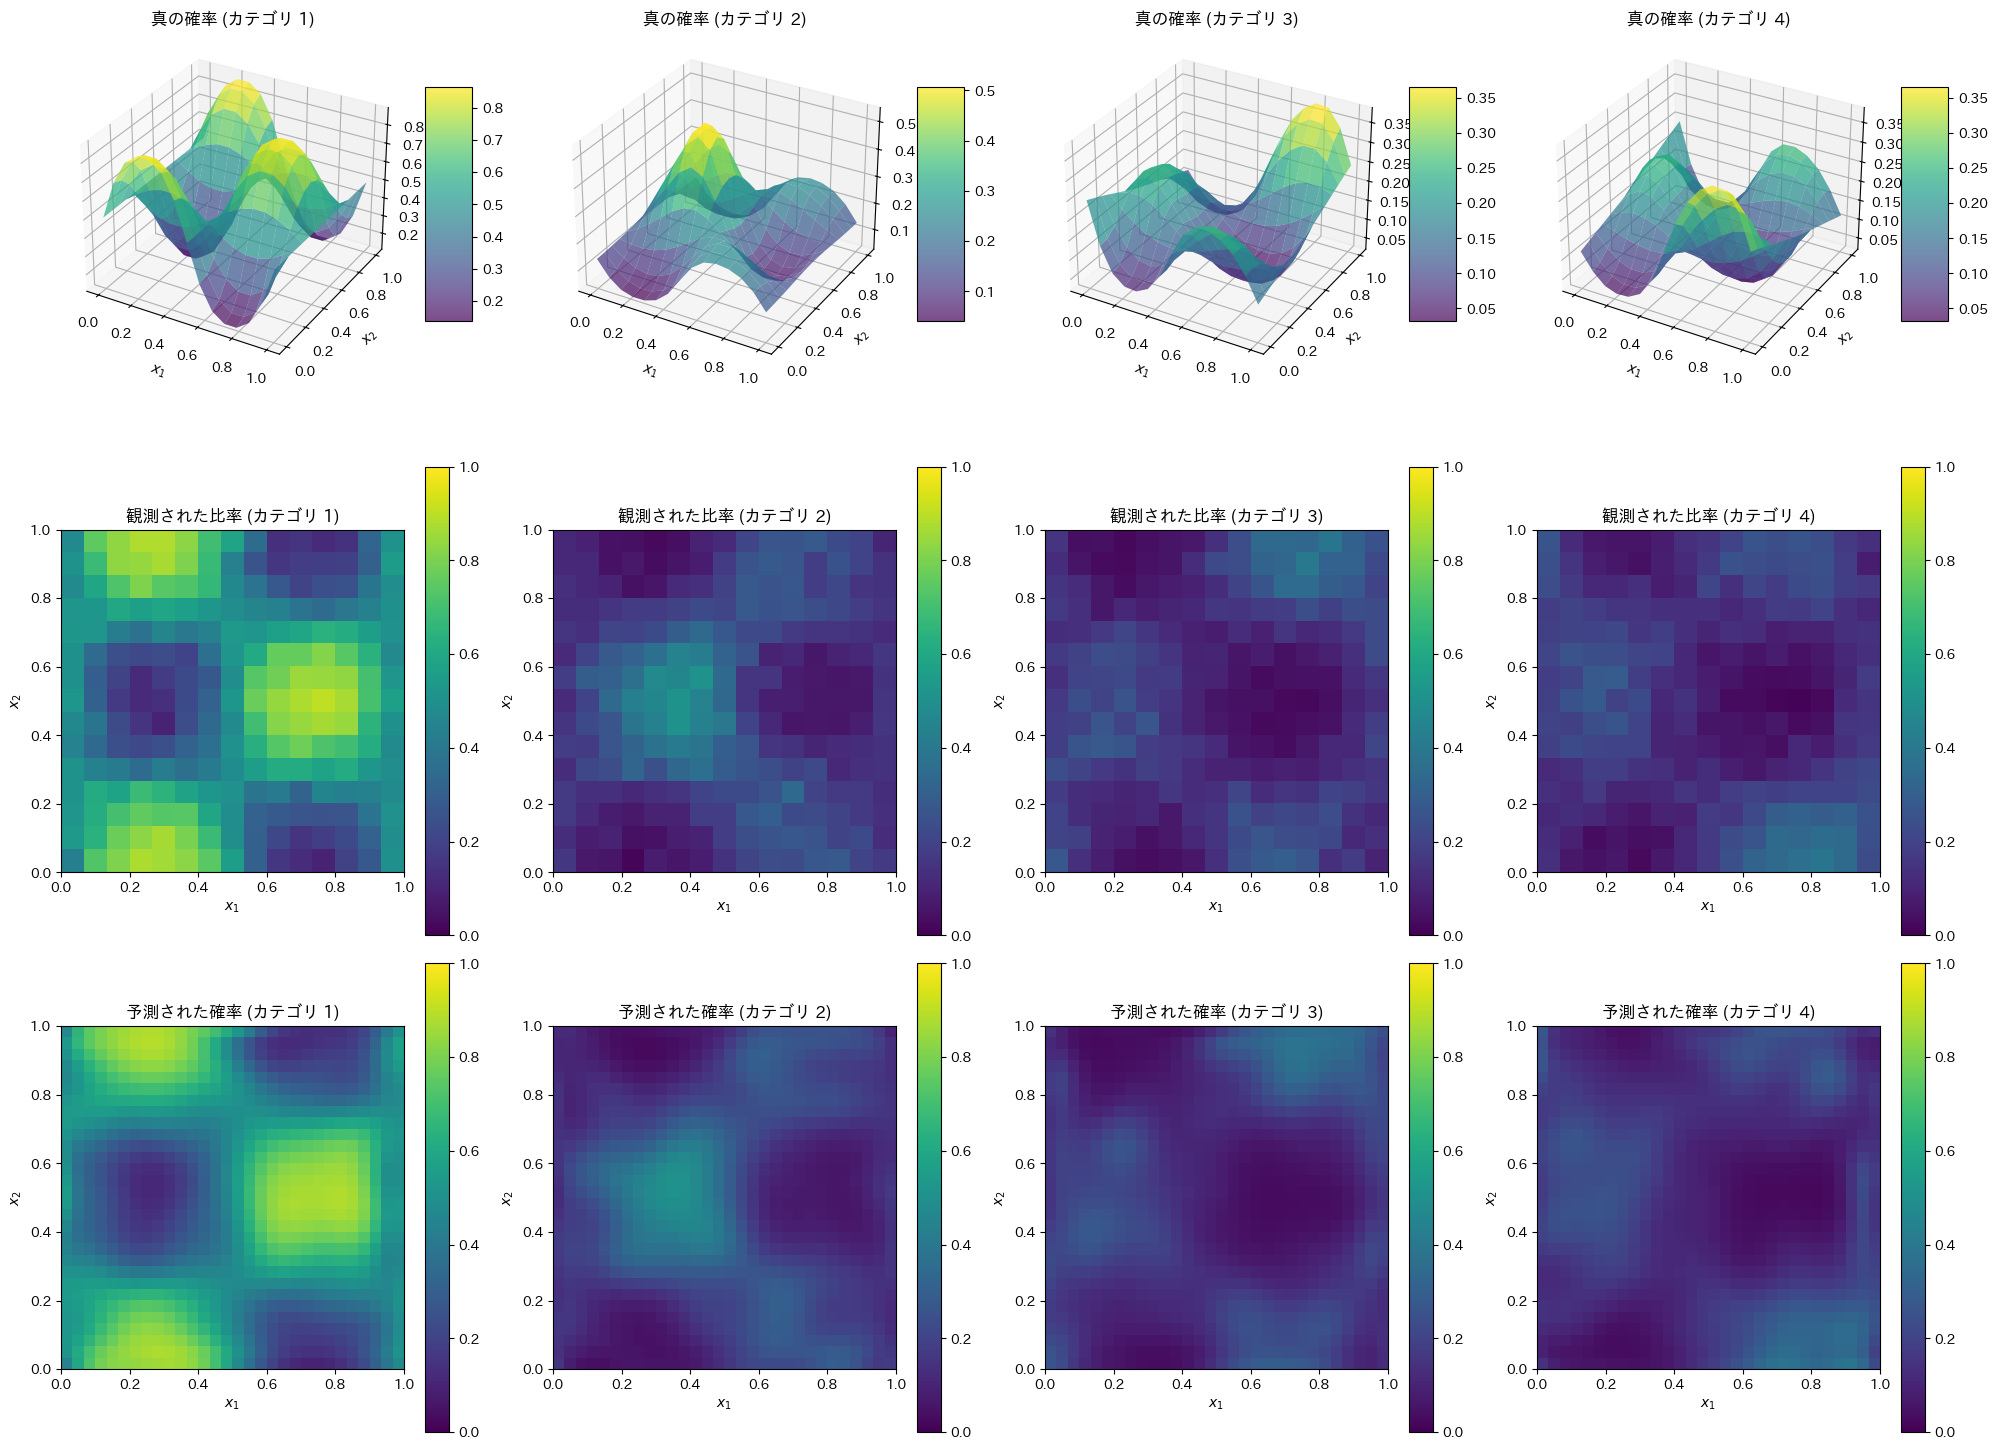

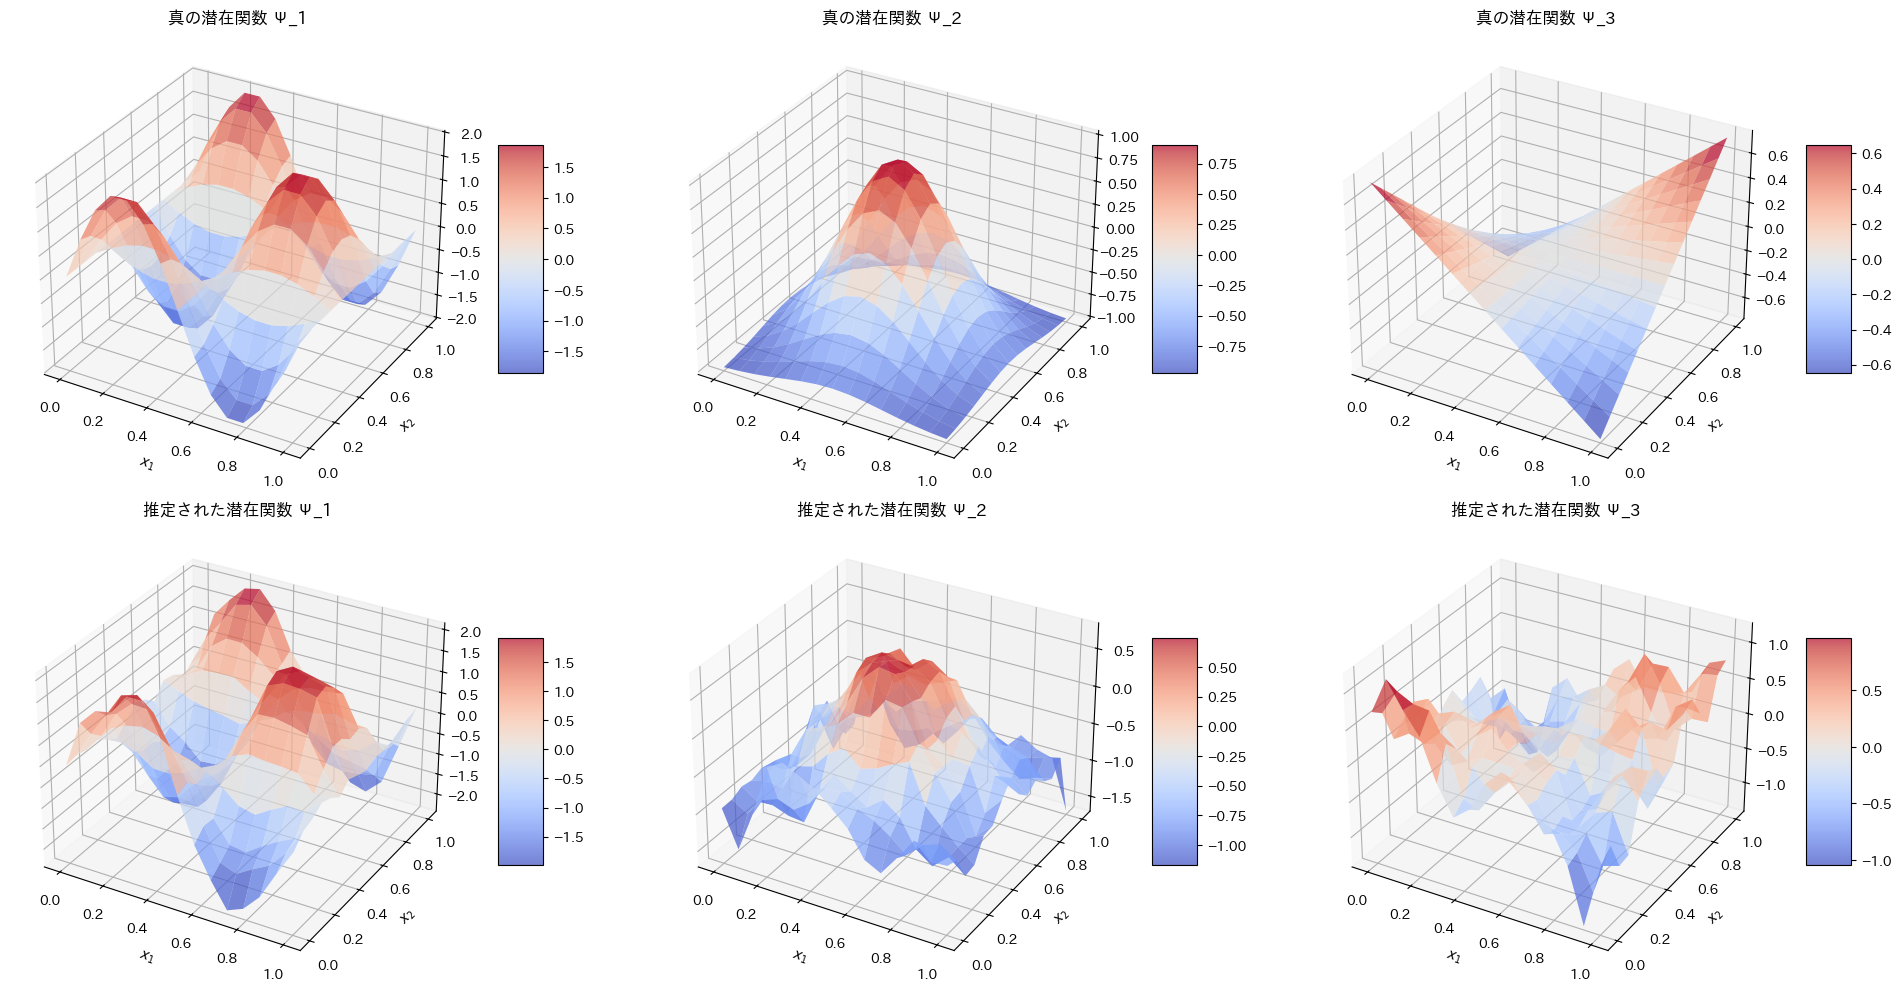

In [36]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pypolyagamma import PyPolyaGamma
from tqdm import tqdm
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

# ロジスティック関数
def logistic(x):
    return 1 / (1 + np.exp(-x))

# スティックブレイキング変換でψからπへ変換
def psi_to_pi(psi):
    K = len(psi) + 1
    pi = np.zeros(K)
    stick_remainder = 1.0
    
    for k in range(K-1):
        pi[k] = stick_remainder * logistic(psi[k])
        stick_remainder -= pi[k]
    
    pi[K-1] = stick_remainder
    return pi

# 二乗指数（RBF）カーネル
def rbf_kernel(Z, sigma=1.0, length_scale=1.0):
    """
    RBFカーネル関数
    
    引数:
        Z: 共変量行列 (M x D)
        sigma: 出力スケール
        length_scale: バンド幅
    
    戻り値:
        カーネル行列 (M x M)
    """
    M = Z.shape[0]
    K = np.zeros((M, M))
    
    for i in range(M):
        for j in range(M):
            # ユークリッド距離の二乗
            sq_dist = np.sum((Z[i] - Z[j])**2)
            K[i, j] = sigma**2 * np.exp(-0.5 * sq_dist / (length_scale**2))
    
    # 数値的安定性のために対角成分に小さな値を追加
    K = K + np.eye(M) * 1e-6
    
    return K

# 多項分布ガウス過程モデルのギブスサンプラー
def gibbs_sampler_multinomial_gp(X, C, n_samples, burn_in, thin=1):
    """
    多項分布ガウス過程モデルのギブスサンプラー
    
    引数:
        X: カウントデータ (M x K)
        C: 共分散行列 (M x M)
        n_samples: サンプル数
        burn_in: バーンイン期間
        thin: 間引き間隔
    
    戻り値:
        サンプルされた潜在GP値とパラメータ
    """
    M, K = X.shape
    K = K  # カテゴリ数
    
    # Pólya-gammaサンプラーの初期化
    pg = PyPolyaGamma()
    
    # 共分散行列の逆行列を計算
    C_inv = np.linalg.inv(C)
    
    # 平均関数の事前分布
    mu0 = np.zeros(M)
    Sigma0 = np.eye(M) * 10.0  # 広い事前分布
    Sigma0_inv = np.linalg.inv(Sigma0)
    
    # パラメータの初期化
    Psi = np.random.normal(0, 1, size=(M, K-1))  # 潜在GP値
    mu = np.zeros((K-1, M))  # 平均関数
    omega = np.ones((M, K-1))  # Pólya-gamma変数
    
    # 結果保存用の配列
    samples_Psi = np.zeros((n_samples, M, K-1))
    samples_mu = np.zeros((n_samples, K-1, M))
    
    # メインのギブスサンプリングループ
    total_iterations = burn_in + n_samples * thin
    
    for t in tqdm(range(total_iterations)):
        # 1. Pólya-gamma変数のサンプリング
        for m in range(M):
            # スティックブレイキングで必要なカウントの調整
            N_remaining = np.sum(X[m])
            
            for k in range(K-1):
                # N_k の計算
                if k == 0:
                    N_k = N_remaining
                else:
                    N_k = N_remaining - np.sum(X[m, :k])
                
                # ω_m,k のサンプリング
                omega[m, k] = pg.pgdraw(N_k, Psi[m, k])
        
        # 2. 各カテゴリkに対する潜在GP値のサンプリング
        for k in range(K-1):
            # 対角行列Ωの作成
            Omega_k = np.diag(omega[:, k])
            
            # κベクトルの作成
            kappa_k = np.zeros(M)
            N_remaining = np.sum(X, axis=1)
            
            for m in range(M):
                if k == 0:
                    N_k = N_remaining[m]
                else:
                    N_k = N_remaining[m] - np.sum(X[m, :k])
                
                kappa_k[m] = X[m, k] - N_k / 2
            
            # 事後共分散と平均の計算
            Sigma_post_inv = Omega_k + C_inv
            Sigma_post = np.linalg.inv(Sigma_post_inv)
            
            mu_post = Sigma_post @ (kappa_k + C_inv @ mu[k])
            
            # 潜在GP値のサンプリング
            Psi[:, k] = np.random.multivariate_normal(mu_post, Sigma_post)
        
        # 3. 平均関数のサンプリング
        for k in range(K-1):
            # 事後共分散と平均の計算
            Sigma_post_inv = C_inv + Sigma0_inv
            Sigma_post = np.linalg.inv(Sigma_post_inv)
            
            mu_post = Sigma_post @ (C_inv @ Psi[:, k] + Sigma0_inv @ mu0)
            
            # 平均関数のサンプリング
            mu[k] = np.random.multivariate_normal(mu_post, Sigma_post)
        
        # バーンイン期間後のサンプル保存
        if t >= burn_in and (t - burn_in) % thin == 0:
            idx = (t - burn_in) // thin
            samples_Psi[idx] = Psi
            samples_mu[idx] = mu
    
    return {
        "Psi": samples_Psi,
        "mu": samples_mu
    }

# 予測関数
def predict_multinomial_probs(samples, C, C_star, C_star_star, n_pred=20):
    """
    新しい共変量点での多項確率の予測
    
    引数:
        samples: ギブスサンプラーからのサンプル
        C: 学習データの共分散行列 (M x M)
        C_star: 学習データと予測点の間の共分散 (n_new x M)
        C_star_star: 予測点の共分散 (n_new x n_new)
        n_pred: 予測に使用するサンプル数
    
    戻り値:
        予測された多項確率
    """
    n_samples = samples["Psi"].shape[0]
    M, K_minus_1 = samples["Psi"].shape[1], samples["Psi"].shape[2]
    K = K_minus_1 + 1
    n_new = C_star.shape[0]
    
    # 直近のn_predサンプルを使用
    if n_samples < n_pred:
        n_pred = n_samples
    
    start_idx = n_samples - n_pred
    
    # 予測結果を保存する配列
    pred_probs = np.zeros((n_pred, n_new, K))
    
    # 共分散行列の逆行列を計算
    C_inv = np.linalg.inv(C)
    
    # 各サンプルについて予測
    for i in range(n_pred):
        sample_idx = start_idx + i
        Psi_sample = samples["Psi"][sample_idx]
        mu_sample = samples["mu"][sample_idx]
        
        # 各カテゴリについて予測
        Psi_pred = np.zeros((n_new, K_minus_1))
        
        for k in range(K_minus_1):
            # GPの条件付き分布からの予測
            mean_pred = C_star @ C_inv @ Psi_sample[:, k]
            cov_pred = C_star_star - C_star @ C_inv @ C_star.T
            
            # 数値的安定性のための対角項の追加
            cov_pred += np.eye(n_new) * 1e-6
            
            # 予測分布からサンプリング
            Psi_pred[:, k] = np.random.multivariate_normal(mean_pred, cov_pred)
        
        # スティックブレイキング変換で確率に変換
        for j in range(n_new):
            pred_probs[i, j] = psi_to_pi(Psi_pred[j])
    
    # 平均予測確率
    mean_probs = np.mean(pred_probs, axis=0)
    
    return mean_probs

# 2次元データの例
if __name__ == "__main__":
    # 2次元データの生成
    n_grid = 15  # グリッド数 (各次元)
    K = 4  # カテゴリ数
    
    # 格子点上の共変量の生成
    x1_range = np.linspace(0, 1, n_grid)
    x2_range = np.linspace(0, 1, n_grid)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    Z = np.column_stack([X1.flatten(), X2.flatten()])
    M = Z.shape[0]  # データ数 = n_grid^2
    
    # 共分散行列の計算
    C = rbf_kernel(Z, sigma=1.0, length_scale=0.2)
    
    # 真のパラメータ（デモンストレーション用）
    # 2次元の関数として潜在関数を定義
    def true_psi1(z1, z2):
        return 2 * np.sin(2 * np.pi * z1) * np.cos(2 * np.pi * z2)
    
    def true_psi2(z1, z2):
        return -1 + 2 * np.exp(-10 * ((z1-0.5)**2 + (z2-0.5)**2))
    
    def true_psi3(z1, z2):
        return 3 * (z1 - 0.5) * (z2 - 0.5)
    
    true_psi1_values = np.array([true_psi1(z[0], z[1]) for z in Z])
    true_psi2_values = np.array([true_psi2(z[0], z[1]) for z in Z])
    true_psi3_values = np.array([true_psi3(z[0], z[1]) for z in Z])
    
    # 真の確率の計算
    true_probs = np.zeros((M, K))
    for m in range(M):
        true_probs[m] = psi_to_pi(np.array([true_psi1_values[m], true_psi2_values[m], true_psi3_values[m]]))
    
    # カウントデータの生成
    N = 200  # 各観測の総カウント
    X = np.zeros((M, K), dtype=int)
    for m in range(M):
        X[m] = np.random.multinomial(N, true_probs[m])
    
    # ギブスサンプリングの実行
    n_samples = 500
    burn_in = 300
    thin = 2
    
    print("ギブスサンプリングを開始...")
    samples = gibbs_sampler_multinomial_gp(X, C, n_samples, burn_in, thin)
    print("サンプリング完了！")
    
    # 予測のためのグリッドを生成
    print("予測のためのグリッドを生成中...")
    n_pred_grid = 30
    pred_x1_range = np.linspace(0, 1, n_pred_grid)
    pred_x2_range = np.linspace(0, 1, n_pred_grid)
    pred_X1, pred_X2 = np.meshgrid(pred_x1_range, pred_x2_range)
    Z_pred = np.column_stack([pred_X1.flatten(), pred_X2.flatten()])
    
    # 予測に必要な共分散行列の計算
    C_star_star = rbf_kernel(Z_pred, sigma=1.0, length_scale=0.2)
    
    # 学習データと予測点の間の共分散
    C_star = np.zeros((Z_pred.shape[0], M))
    for m in range(Z_pred.shape[0]):
        for j in range(M):
            sq_dist = np.sum((Z_pred[m] - Z[j])**2)
            C_star[m, j] = np.exp(-0.5 * sq_dist / 0.2**2)
    
    print("予測を実行中...")
    pred_probs = predict_multinomial_probs(samples, C, C_star, C_star_star)
    
    # 結果の可視化
    print("結果の可視化中...")
    
    # カラーマップの設定
    cmap = cm.viridis
    
    # 図の設定
    fig = plt.figure(figsize=(20, 15))
    
    # 3x4のグリッドで可視化
    # 上段：真の確率
    # 中段：観測データ
    # 下段：予測確率
    
    # 真の確率
    true_probs_grid = true_probs.reshape(n_grid, n_grid, K)
    for k in range(K):
        ax = fig.add_subplot(3, K, k+1, projection='3d')
        surf = ax.plot_surface(X1, X2, true_probs_grid[:,:,k], cmap=cmap, 
                              antialiased=True, alpha=0.7)
        ax.set_title(f'真の確率 (カテゴリ {k+1})')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel('確率')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # 観測された比率
    observed_ratio = X / N
    observed_ratio_grid = observed_ratio.reshape(n_grid, n_grid, K)
    for k in range(K):
        ax = fig.add_subplot(3, K, K+k+1)
        im = ax.imshow(observed_ratio_grid[:,:,k], cmap=cmap, origin='lower', 
                      extent=[0, 1, 0, 1], vmin=0, vmax=1)
        ax.set_title(f'観測された比率 (カテゴリ {k+1})')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        fig.colorbar(im, ax=ax)
    
    # 予測確率
    pred_probs_grid = pred_probs.reshape(n_pred_grid, n_pred_grid, K)
    for k in range(K):
        ax = fig.add_subplot(3, K, 2*K+k+1)
        im = ax.imshow(pred_probs_grid[:,:,k], cmap=cmap, origin='lower', 
                      extent=[0, 1, 0, 1], vmin=0, vmax=1)
        ax.set_title(f'予測された確率 (カテゴリ {k+1})')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    # 追加の可視化：潜在関数の推定
    fig = plt.figure(figsize=(20, 10))
    
    # 真の潜在関数
    true_psi_functions = [true_psi1_values, true_psi2_values, true_psi3_values]
    
    # 推定された潜在関数（最後のサンプル）
    estimated_psi = samples["Psi"][-1]  # 最後のサンプル
    
    for k in range(K-1):
        # 真の潜在関数
        ax = fig.add_subplot(2, K-1, k+1, projection='3d')
        Z_grid = true_psi_functions[k].reshape(n_grid, n_grid)
        surf = ax.plot_surface(X1, X2, Z_grid, cmap=cm.coolwarm, 
                              antialiased=True, alpha=0.7)
        ax.set_title(f'真の潜在関数 Ψ_{k+1}')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        
        # 推定された潜在関数
        ax = fig.add_subplot(2, K-1, K-1+k+1, projection='3d')
        Z_grid = estimated_psi[:, k].reshape(n_grid, n_grid)
        surf = ax.plot_surface(X1, X2, Z_grid, cmap=cm.coolwarm, 
                              antialiased=True, alpha=0.7)
        ax.set_title(f'推定された潜在関数 Ψ_{k+1}')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()